In [216]:
import textwrap
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from typing import Optional

In [217]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings()

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

In [218]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./documentos/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=200
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [219]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

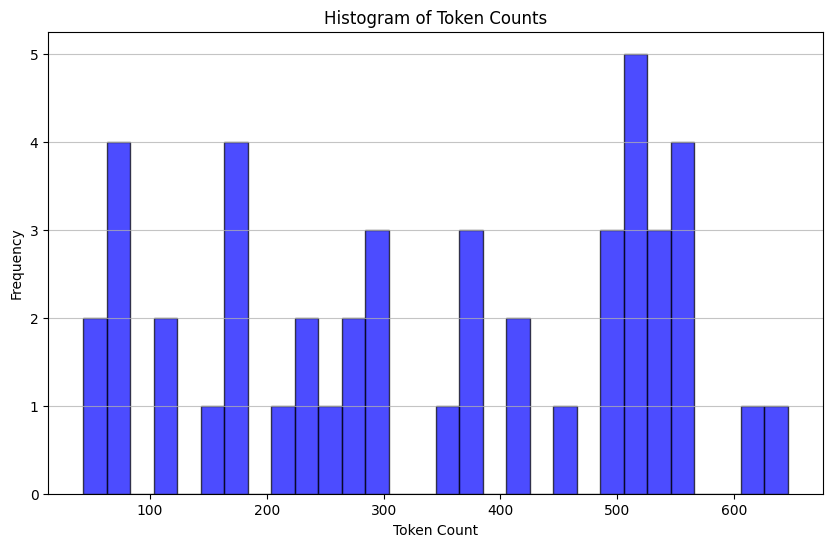

In [220]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [221]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 15830


# Se debe encontrar la manera de guardar los vectores de un embeding de manera local, para ahorrar en embeddings.

In [222]:
global_embeddings = [embeddings.embed_query(txt) for txt in texts]

In [223]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced

array([[-2.9918356 ,  2.7408974 ],
       [-2.941183  ,  2.6618495 ],
       [-2.5873475 ,  2.9737618 ],
       [-2.453369  ,  4.152145  ],
       [-3.3203304 ,  2.564386  ],
       [-1.1021566 ,  4.258525  ],
       [-1.0313594 ,  4.876079  ],
       [-0.72377074,  4.965778  ],
       [-0.83773685,  5.824864  ],
       [-0.65957785,  6.0626206 ],
       [-1.6637859 ,  6.3979974 ],
       [-1.6146492 ,  6.2632747 ],
       [-1.2691251 ,  4.651882  ],
       [-0.7617659 ,  3.6230342 ],
       [ 0.06276163,  4.5634866 ],
       [-0.1779203 ,  4.5155697 ],
       [-2.1308525 ,  4.7433014 ],
       [-0.26600957,  3.7695985 ],
       [-0.5329864 ,  4.3043947 ],
       [-1.3044153 ,  3.786159  ],
       [ 0.17872207,  4.1789737 ],
       [-1.084684  ,  5.694123  ],
       [-1.0793259 ,  6.9295025 ],
       [-1.2127445 ,  6.805071  ],
       [-1.2255478 ,  6.123056  ],
       [-3.5252204 ,  2.8182228 ],
       [-0.42180583,  3.2077012 ],
       [ 1.0671333 ,  3.1792076 ],
       [-0.34389582,

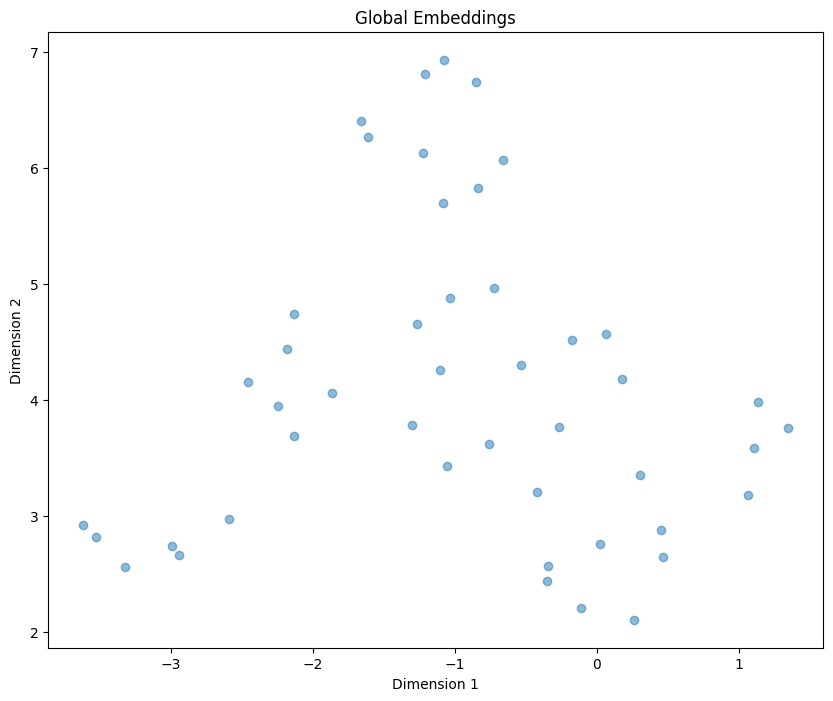

In [224]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

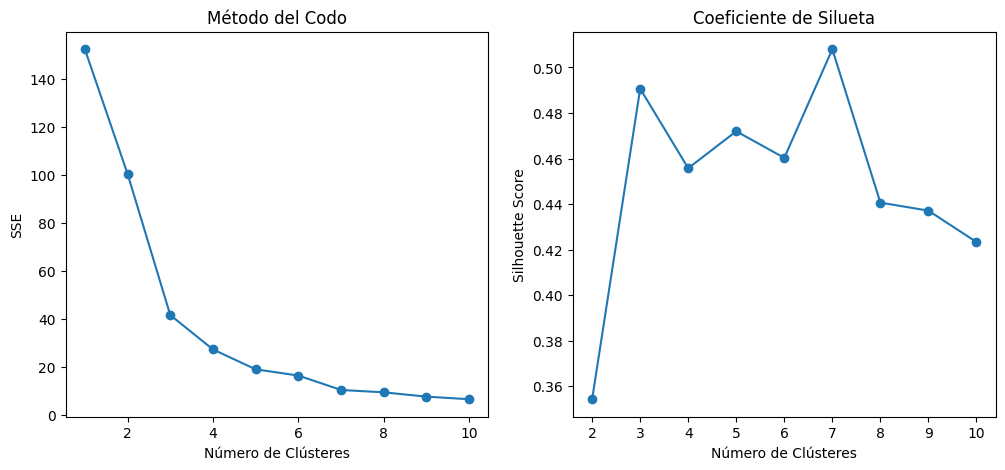

In [225]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

# Método del Codo
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    sse.append(kmeans.inertia_)

# Coeficiente de Silueta
silhouette_scores = []
for k in k_values[1:]:  # Silhouette score no está definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    score = silhouette_score(global_embeddings_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE')

# Graficar el coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Silhouette Score')

plt.show()

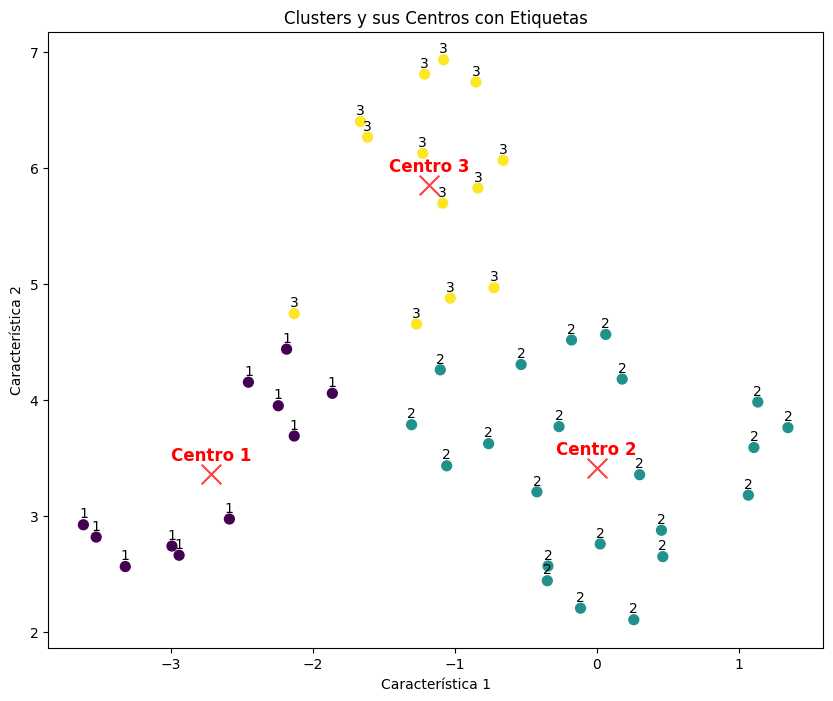

In [226]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Suponiendo que 'global_embeddings_reduced' ya está definido
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(global_embeddings_reduced)
labels = kmeans.labels_ + 1  # Agregar 1 a las etiquetas de los clústeres
centers = kmeans.cluster_centers_

# Visualizar los datos y los centros de los clústeres
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

# Añadir etiquetas a los puntos de datos
for i in range(len(global_embeddings_reduced)):
    plt.annotate(str(labels[i]), (global_embeddings_reduced[i, 0], global_embeddings_reduced[i, 1]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Añadir etiquetas a los centros de los clústeres
for i, center in enumerate(centers):
    plt.annotate(f'Centro {i+1}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12, weight='bold')

plt.title("Clusters y sus Centros con Etiquetas")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

In [227]:
print(len(texts))
print(len(global_embeddings_reduced))

46
46


In [228]:
df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': labels
})
df.head()

,Texto,Embedding,Cluster
0,Metodología de enseñanza y para el aprendiza...,"[-2.9918356, 2.7408974]",1
1,Global Campus Nebrija Metodología de ense ...,"[-2.941183, 2.6618495]",1
2,Metodología de enseñanza y para el aprendizaje...,"[-2.5873475, 2.9737618]",1
3,"y evolución de los cursos MOOC, pero sin perde...","[-2.453369, 4.152145]",1
4,Metodología de enseñanza y para el aprendizaje...,"[-3.3203304, 2.564386]",1


In [229]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{1: 'Metodología de  enseñanza y para  el aprendizaje  para cursos  MOOC   Documento marco  Global Campus Nebrija       Versión  Fecha  Motivo de  modificación  Elaboración  Revisión  Aprobación   1 Febrero  2016   Global  Campus  Nebrija --- Global Campus Nebrija     Metodología de ense ñanza y aprendizaje para cursos MOOC            [2]                                                       Febrero 2016 Índice   Presentación  3    Capítulo 1:  Introducción a los cursos MOOC   1.1. ¿Qué son los MOOC?  5  1.2. Origen y evolución  7  1.3. Tipología  11  1.4. Plataformas  16    Capítulo 2: MOOC: Metodología de enseñanza y aprendizaje   2.1. Definición de una metodología MOOC  21  2.2. Tipo de curso y plataforma  21  2.2. Diseño del curso  22  2.3. Estructura, contenido y secuencias didácticas  23  2.3.1. Módulos  23  2.3.2. Licencias para el contenido  24  2.4. Evaluación  25  2.4.1. P2P: Evaluación “Peer to peer” y rúbricas  25  2.4.2. Badges y certificación  25  2.5. Canales de comunica

# Hay que volver a hacer un split de texto para solucionar problemas de capacidad en el LLM.

In [230]:
from langchain_core.output_parsers import StrOutputParser

template = """Eres Prometeo, un asistente capaz de crear resumenes detallados y concisos del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | turbo_llm | StrOutputParser()

In [231]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{1: 'Este documento marco proporciona una guía para el diseño de cursos virtuales MOOC, abordando temas como la definición de una metodología MOOC, el diseño del curso, la evaluación, los canales de comunicación, el profesorado y el alumnado. Se destaca la importancia de la tecnología en la enseñanza, pero se enfatiza que el diseño pedagógico es crucial. Se menciona la necesidad de adaptar la metodología a las características del medio tecnológico y del curso en cuestión. También se hace referencia a la revisión bibliográfica realizada sobre cursos MOOC, con énfasis en el enfoque práctico, interactivo y participativo. Además, se incluye una lista de bibliografía consultada para la elaboración de este documento.',
 2: 'En resumen, los MOOC (Massive Open Online Course) son cursos virtuales masivos, abiertos y gratuitos, que se caracterizan por su accesibilidad global a través de plataformas tecnológicas. Existen diferentes tipos de MOOC, como transferMOOCs, madeMOOCs, syncMOOCs, asynchMO

In [232]:
clustered_summaries = {}
for label, summary in zip(labels, summaries.values()):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(summary)

clustered_summaries

{1: ['Este documento marco proporciona una guía para el diseño de cursos virtuales MOOC, abordando temas como la definición de una metodología MOOC, el diseño del curso, la evaluación, los canales de comunicación, el profesorado y el alumnado. Se destaca la importancia de la tecnología en la enseñanza, pero se enfatiza que el diseño pedagógico es crucial. Se menciona la necesidad de adaptar la metodología a las características del medio tecnológico y del curso en cuestión. También se hace referencia a la revisión bibliográfica realizada sobre cursos MOOC, con énfasis en el enfoque práctico, interactivo y participativo. Además, se incluye una lista de bibliografía consultada para la elaboración de este documento.',
  'En resumen, los MOOC (Massive Open Online Course) son cursos virtuales masivos, abiertos y gratuitos, que se caracterizan por su accesibilidad global a través de plataformas tecnológicas. Existen diferentes tipos de MOOC, como transferMOOCs, madeMOOCs, syncMOOCs, asynchMOO

In [233]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{1: 'El documento marco proporciona una guía detallada para el diseño de cursos virtuales MOOC, enfatizando la importancia del diseño pedagógico y la adaptación de la metodología al entorno tecnológico. Se mencionan diferentes tipos de MOOC, como xMOOC y cMOOC, que se centran en la teoría instructivista y el conectivismo respectivamente. Los cursos MOOC presentan desafíos como altas tasas de abandono y la necesidad de formación del profesorado. La evaluación incluye quizzes, actividades P2P y badges, mientras que los estudiantes deben poseer competencias tecnológicas y de autorregulación del aprendizaje. En cuanto a la metodología, se destaca la importancia de definir el tipo de curso y plataforma, diseñar el curso, estructurar el contenido por módulos y establecer actividades de evaluación y canales de comunicación. Se abordan también aspectos como la diversidad del alumnado, las motivaciones para la creación de cursos MOOC, el impacto en el sistema educativo y las principales platafo

In [234]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [235]:
vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embeddings)

In [241]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuáles son las competencias del profesorado?", 10000, 4)
final_number

9

In [242]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [243]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de lectura que habla Español.

Tu tarea consiste en:

1. Ser carismático y ofrecer información sobre ti y tus funciones.

2. Leer detalladamente la información proporcionada en documentos
de texto en formato PDF, para ser capaz de dar respuestas a cualquier tipo de pregunta,
en especial a preguntas puntuales.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables del contexto.

Teniendo lo anterior en cuenta, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

In [244]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

¿Cuáles son las competencias del profesorado?
Las competencias del profesorado son las siguientes:  1. Adaptación a
nuevas modalidades de aprendizaje tanto como usuario y como diseñador
de escenarios de aprendizaje con uso de TIC. 2. Integración de
recursos digitales como instrumento, contenido o material didáctico en
planes curriculares. 3. Selección y evaluación objetiva de recursos
digitales para su incorporación en prácticas pedagógicas
contextualizadas, diseño, implementación y uso de la tecnología. 4.
Diseño y producción de recursos digitales con fines didácticos. 5.
Desarrollo de planes de evaluación con el uso de TIC. 6. Empleo de TIC
para funciones de asesoría, orientación y seguimiento de los
estudiantes. 7. Iniciar y mantener debates interactivos. 8.
Entendimiento del aprendizaje colaborativo, constructivo, reflexivo,
activo y auténtico.


In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

### 2. Recordar (si y solo si Enseñar=Done)

In [ ]:
# Now we can load the persisted database from disk, and use it as normal. 
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)
retriever = vectordb.as_retriever(search_kwargs={"k": 5})
#retriever = vectordb.as_retriever()